(basic-image)=

# Image manipulation and processing using NumPy and SciPy

**Authors**: _Emmanuelle Gouillart, Gaël Varoquaux_

In [1]:
# Our usual imports.
import numpy as np
import matplotlib.pyplot as plt

This section addresses basic image manipulation and processing using the
core scientific modules NumPy and SciPy. Some of the operations covered
by this tutorial may be useful for other kinds of multidimensional array
processing than image processing. In particular, the submodule
{mod}`scipy.ndimage` provides functions operating on n-dimensional NumPy
arrays.

:::{admonition} See also

For more advanced image processing and image-specific routines, see the
tutorial {ref}`scikit-image`, dedicated to the {mod}`skimage` module.

:::

:::{admonition} Image = 2-D numerical array
(or 3-D: CT, MRI, 2D + time; 4-D, ...)

Here, **image == NumPy array** `np.array`

:::

**Tools used in this tutorial**:

- `numpy`: basic array manipulation
- `scipy`: `scipy.ndimage` submodule dedicated to image processing
  (n-dimensional images). See the [documentation](https://docs.scipy.org/doc/scipy/tutorial/ndimage.html):

In [2]:
import scipy as sp

**Common tasks in image processing**:

- Input/Output, displaying images
- Basic manipulations: cropping, flipping, rotating, ...
- Image filtering: denoising, sharpening
- Image segmentation: labeling pixels corresponding to different objects
- Classification
- Feature extraction
- Registration

- ...

## Opening and writing to image files

Writing an array to an image file:

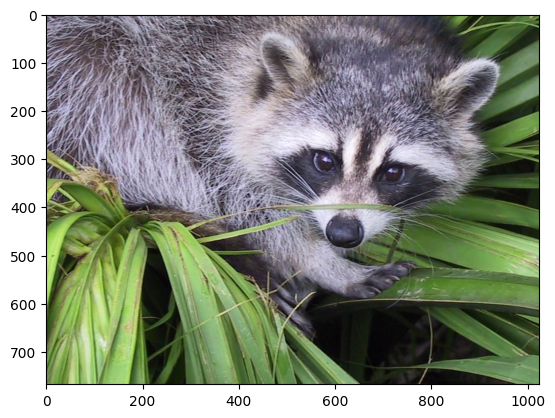

In [3]:
import scipy as sp
import imageio.v3 as iio

f = sp.datasets.face()
iio.imwrite("face.png", f)  # uses the Image module (PIL)

plt.imshow(f)

In [4]:
face = iio.imread('face.png')
type(face)

numpy.ndarray

In [5]:
face.shape, face.dtype

((768, 1024, 3), dtype('uint8'))

`dtype` is `uint8` for 8-bit images (0-255)

Opening raw files (camera, 3-D images)

In [6]:
face.tofile('face.raw') # Create raw file
face_from_raw = np.fromfile('face.raw', dtype=np.uint8)
face_from_raw.shape
face_from_raw.shape = (768, 1024, 3)

Need to know the shape and dtype of the image (how to separate data
bytes).

For large data, use `np.memmap` for memory mapping:

In [7]:
face_memmap = np.memmap('face.raw', dtype=np.uint8, shape=(768, 1024, 3))

(data are read from the file, and not loaded into memory)

Working on a list of image files

In [8]:
rng = np.random.default_rng(27446968)
for i in range(10):
    im = rng.integers(0, 256, 10000, dtype=np.uint8).reshape((100, 100))
    iio.imwrite(f'random_{i:02d}.png', im)
from glob import glob
filelist = sorted(glob('random*.png'))
filelist

['random_00.png',
 'random_01.png',
 'random_02.png',
 'random_03.png',
 'random_04.png',
 'random_05.png',
 'random_06.png',
 'random_07.png',
 'random_08.png',
 'random_09.png']

## Displaying images

Use `matplotlib` and `imshow` to display an image inside a
`matplotlib figure`:

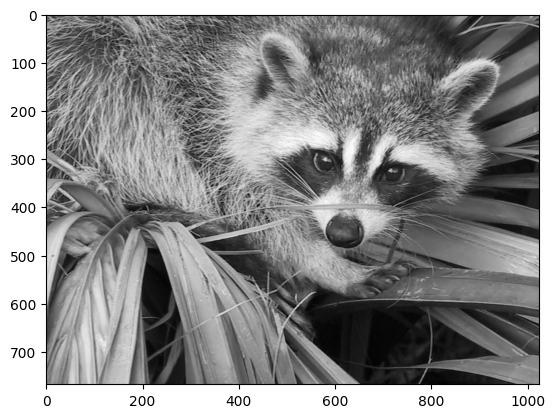

In [9]:
f = sp.datasets.face(gray=True)  # retrieve a grayscale image
plt.imshow(f, cmap=plt.cm.gray)

Increase contrast by setting min and max values:

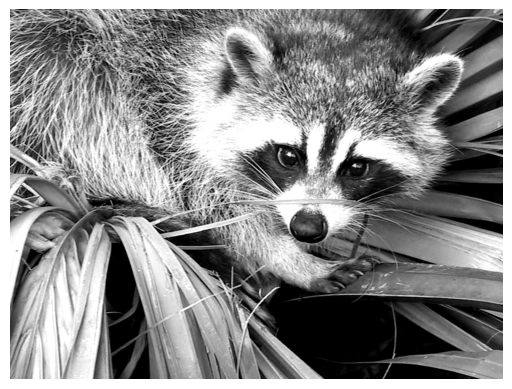

In [10]:
plt.imshow(f, cmap=plt.cm.gray, vmin=30, vmax=200)
# Remove axes and ticks.
# Semicolon ends line to suppress repr of Matplotlib objects.
plt.axis('off');

Draw contour lines:

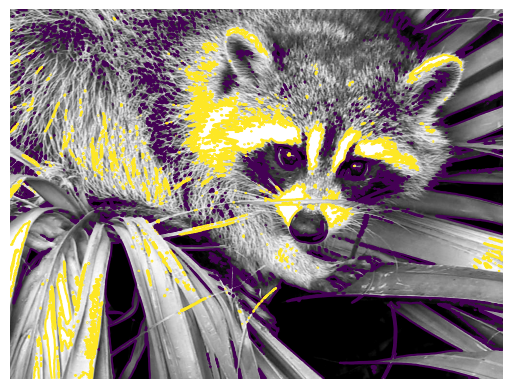

In [11]:
plt.imshow(f, cmap=plt.cm.gray, vmin=30, vmax=200)
plt.contour(f, [50, 200])
plt.axis('off');

For smooth intensity variations, use `interpolation='bilinear'`. For fine inspection of intensity variations, use
`interpolation='nearest'`:

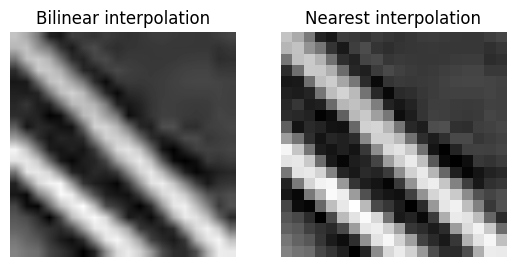

In [12]:
fix, axes = plt.subplots(1, 2)
axes[0].imshow(f[320:340, 510:530], cmap=plt.cm.gray, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Bilinear interpolation')
axes[1].imshow(f[320:340, 510:530], cmap=plt.cm.gray, interpolation='nearest')
axes[1].set_title('Nearest interpolation')
axes[1].axis('off');

:::{admonition} See also

More interpolation methods are in [Matplotlib's examples](https://matplotlib.org/examples/images_contours_and_fields/interpolation_methods.html).
:::

## Basic manipulations

Images are arrays: use the whole `numpy` machinery.

![](axis_convention.png)

In [13]:
face = sp.datasets.face(gray=True)
face[0, 40]

np.uint8(127)

In [14]:
# Slicing
face[10:13, 20:23]

array([[141, 153, 145],
       [133, 134, 125],
       [ 96,  92,  94]], dtype=uint8)

In [15]:
face[100:120] = 255

In [16]:
lx, ly = face.shape
X, Y = np.ogrid[0:lx, 0:ly]
mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4
# Masks
face[mask] = 0
# Fancy indexing
face[range(400), range(400)] = 255

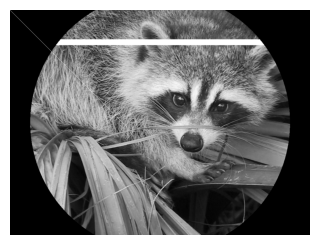

In [17]:
plt.figure(figsize=(3, 3))
plt.axes((0, 0, 1, 1))
plt.imshow(face, cmap="gray")
plt.axis("off");

### Statistical information

In [18]:
face = sp.datasets.face(gray=True)
face.mean()

np.float64(113.48026784261067)

In [19]:
face.max(), face.min()

(np.uint8(250), np.uint8(0))

`np.histogram`

::: {exercise-start}
:label: img-proc-logo-ex
:class: dropdown
:::

- Open as an array the `scikit-image` logo
  (<https://scikit-image.org/_static/img/logo.png>), or an
  image that you have on your computer.
- Crop a meaningful part of the image, for example the python circle
  in the logo.
- Display the image array using `matplotlib`. Change the
  interpolation method and zoom to see the difference.
- Transform your image to greyscale
- Increase the contrast of the image by changing its minimum and
  maximum values. **Optional**: use `scipy.stats.scoreatpercentile`
  (read the docstring!) to saturate 5% of the darkest pixels and 5%
  of the lightest pixels.
- Save the array to two different file formats (png, jpg, tiff)

![](scikit_image_logo.png)

::: {exercise-end}
:::

### Geometrical transformations

In [20]:
face = sp.datasets.face(gray=True)
lx, ly = face.shape
# Cropping
crop_face = face[lx // 4: - lx // 4, ly // 4: - ly // 4]
# up <-> down flip
flip_ud_face = np.flipud(face)
# rotation
rotate_face = sp.ndimage.rotate(face, 45)
rotate_face_noreshape = sp.ndimage.rotate(face, 45, reshape=False)

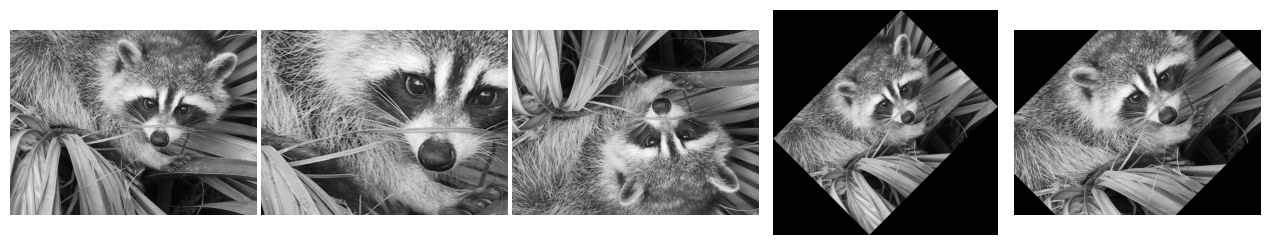

In [21]:
# Plot the transformed face.
fig, axes = plt.subplots(1, 5, figsize=(12.5, 2.5))
for i, img_arr in enumerate([face, crop_face, flip_ud_face,
                             rotate_face, rotate_face_noreshape]):
    axes[i].imshow(img_arr, cmap="gray")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1);

## Image filtering

**Local filters**: replace the value of pixels by a function of the values of
neighboring pixels.

Neighbourhood: square (choose size), disk, or more complicated _structuring
element_.

:::{figure} kernels.png
:align: center
:scale: 90
:::

### Blurring/smoothing

**Gaussian filter** from `scipy.ndimage`:

In [22]:
face = sp.datasets.face(gray=True)
blurred_face = sp.ndimage.gaussian_filter(face, sigma=3)
very_blurred = sp.ndimage.gaussian_filter(face, sigma=5)

**Uniform filter**

In [23]:
local_mean = sp.ndimage.uniform_filter(face, size=11)

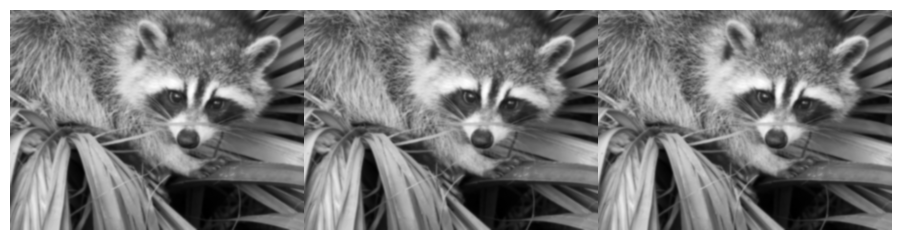

In [24]:
# Plot the figures.
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, img_arr in enumerate([blurred_face, very_blurred, local_mean]):
    axes[i].imshow(blurred_face, cmap="gray")
    axes[i].axis("off")

plt.subplots_adjust(wspace=0, hspace=0.0, top=0.99, bottom=0.01, left=0.01, right=0.99);

### Sharpening

Sharpen a blurred image:

In [25]:
face = sp.datasets.face(gray=True).astype(float)
blurred_f = sp.ndimage.gaussian_filter(face, 3)

Increase the weight of edges by adding an approximation of the
Laplacian:

In [26]:
filter_blurred_f = sp.ndimage.gaussian_filter(blurred_f, 1)
alpha = 30
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

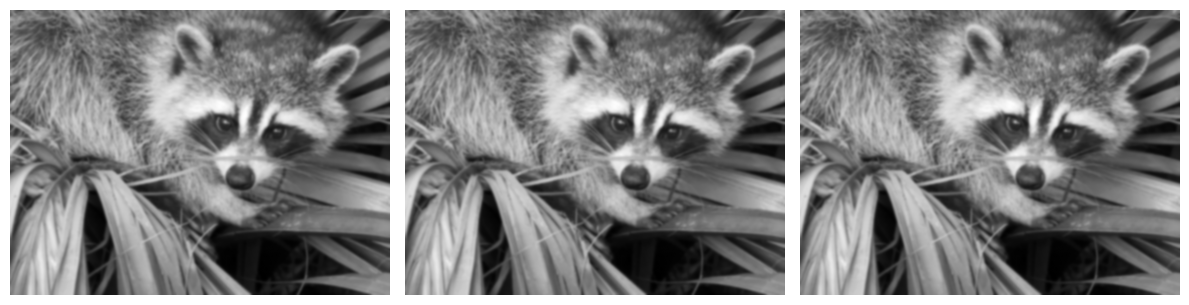

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, img_arr in enumerate([f, blurred_f, sharpened]):
    axes[i].imshow(blurred_face, cmap="gray")
    axes[i].axis("off")

plt.tight_layout();

### Denoising

Noisy face:

In [28]:
f = sp.datasets.face(gray=True)
f = f[230:290, 220:320]

rng = np.random.default_rng()
noisy = f + 0.4 * f.std() * rng.random(f.shape)

A **Gaussian filter** smoothes the noise out... and the edges as well:

In [29]:
gauss_denoised = sp.ndimage.gaussian_filter(noisy, 2)

Most local linear isotropic filters blur the image (`scipy.ndimage.uniform_filter`)

A **median filter** preserves better the edges:

In [30]:
med_denoised = sp.ndimage.median_filter(noisy, 3)

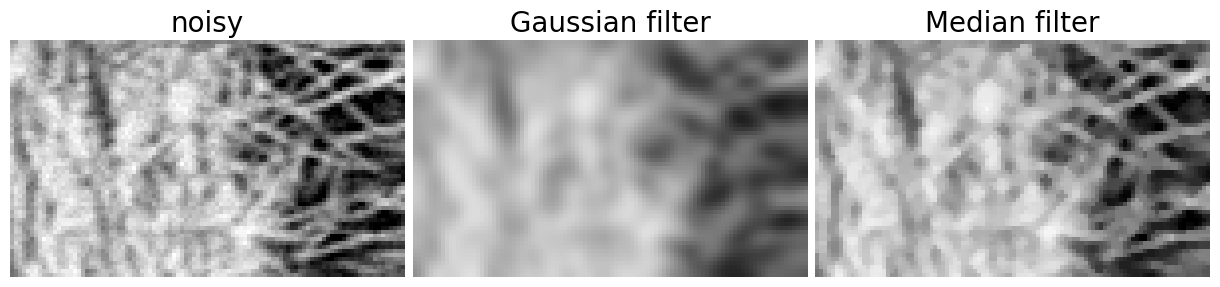

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12, 2.8))
for i, (name, img_arr) in enumerate([
    ['noisy', noisy],
    ['Gaussian filter', gauss_denoised],
    ['Median filter', med_denoised]]):
    axes[i].imshow(img_arr, cmap="gray", vmin=40, vmax=220)
    axes[i].axis("off")
    axes[i].set_title(name, fontsize=20)

plt.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9, bottom=0, left=0, right=1);

Median filter: better result for straight boundaries (**low curvature**):

In [32]:
im = np.zeros((20, 20))
im[5:-5, 5:-5] = 1
im = sp.ndimage.distance_transform_bf(im)
rng = np.random.default_rng()
im_noise = im + 0.2 * rng.standard_normal(im.shape)
im_med = sp.ndimage.median_filter(im_noise, 3)

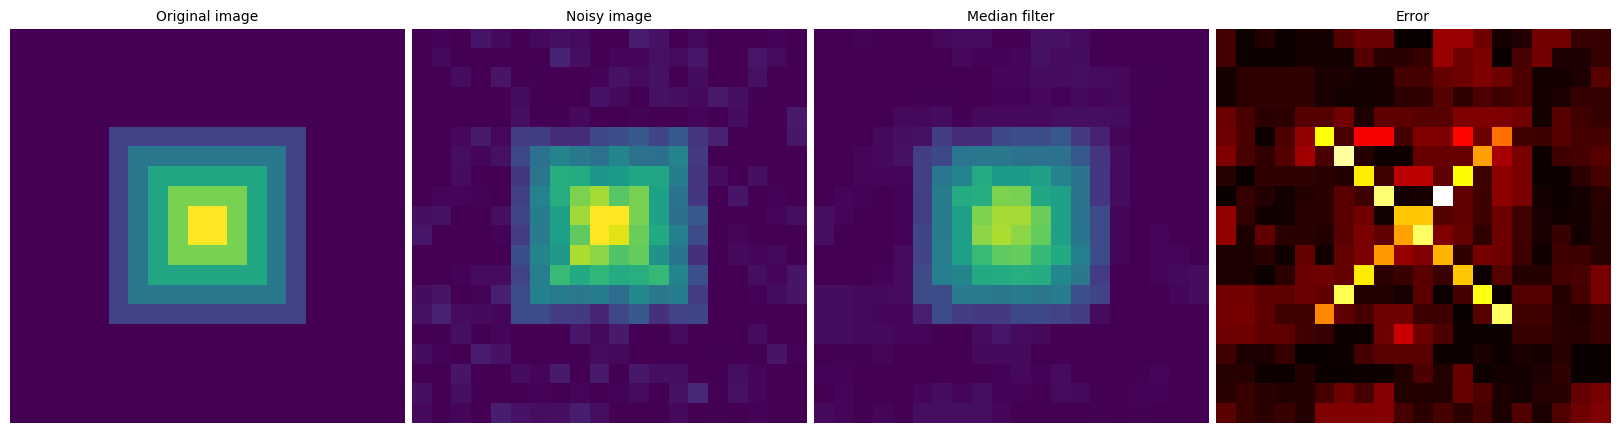

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
for i, (name, img_arr) in enumerate([
    ['Original image', im],
    ['Noisy image', im_noise],
    ['Median filter', im_med]]):
    axes[i].imshow(img_arr, vmin=0, vmax=5)
    axes[i].axis("off")
    axes[i].set_title(name, fontsize=10)
axes[-1].imshow(np.abs(im - im_med), cmap="hot", interpolation="nearest")
axes[-1].axis("off")
axes[-1].set_title('Error', fontsize=10)

plt.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9, bottom=0, left=0, right=1)

Other rank filter: `scipy.ndimage.maximum_filter`,
`scipy.ndimage.percentile_filter`

Other local non-linear filters: Wiener (`scipy.signal.wiener`), etc.

**Non-local filters**

::: {exercise-start}
:label: img-proc-denoise-ex
:class: dropdown
:::

- Create a binary image (of 0s and 1s) with several objects (circles,
  ellipses, squares, or random shapes).
- Add some noise (e.g., 20% of noise)
- Try two different denoising methods for denoising the image:
  gaussian filtering and median filtering.
- Compare the histograms of the two different denoised images.
  Which one is the closest to the histogram of the original (noise-free)
  image?

::: {exercise-end}
:::

:::{admonition} See also

More denoising filters are available in {mod}`skimage.denoising`,
see the {ref}`scikit-image` tutorial.
:::

### Mathematical morphology

See [wikipedia](https://en.wikipedia.org/wiki/Mathematical_morphology)
for a definition of mathematical morphology.

Probe an image with a simple shape (a **structuring element**), and
modify this image according to how the shape locally fits or misses the
image.

**Structuring element**:

In [34]:
el = sp.ndimage.generate_binary_structure(2, 1)
el

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

In [35]:
el.astype(int)

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]])

![](diamond_kernel.png)

**Erosion** = minimum filter. Replace the value of a pixel by the minimal value covered by the structuring element.:

In [36]:
a = np.zeros((7,7), dtype=int)
a[1:6, 2:5] = 1
a

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [37]:
sp.ndimage.binary_erosion(a).astype(a.dtype)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [38]:
# Erosion removes objects smaller than the structure
sp.ndimage.binary_erosion(a, structure=np.ones((5,5))).astype(a.dtype)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

![](morpho_mat.png)

**Dilation**: maximum filter:

In [39]:
a = np.zeros((5, 5))
a[2, 2] = 1
a

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [40]:
sp.ndimage.binary_dilation(a).astype(a.dtype)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

Also works for grey-valued images:

In [41]:
rng = np.random.default_rng(27446968)
im = np.zeros((64, 64))
x, y = (63*rng.random((2, 8))).astype(int)
im[x, y] = np.arange(8)

In [42]:
bigger_points = sp.ndimage.grey_dilation(im, size=(5, 5), structure=np.ones((5, 5)))

In [43]:
square = np.zeros((16, 16))
square[4:-4, 4:-4] = 1
dist = sp.ndimage.distance_transform_bf(square)
dilate_dist = sp.ndimage.grey_dilation(dist, size=(3, 3), \
        structure=np.ones((3, 3)))

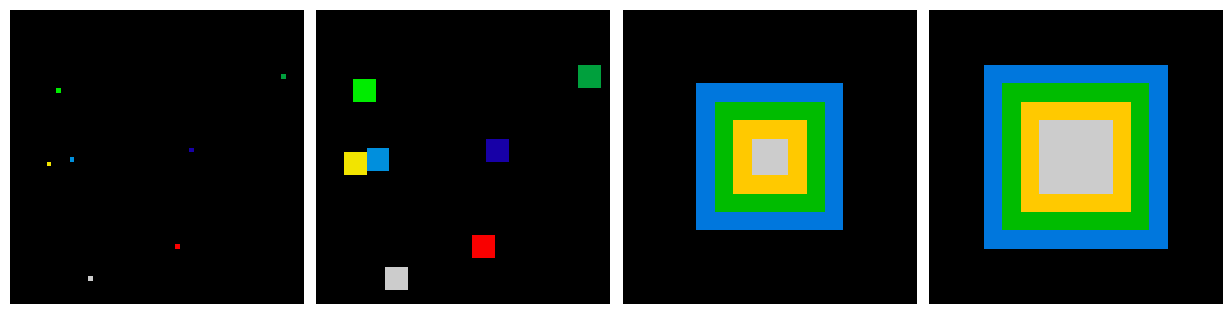

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(12.5, 3))
for i, img_arr in enumerate([im, bigger_points, dist, dilate_dist]):
    axes[i].imshow(img_arr, interpolation='nearest', cmap='nipy_spectral')
    axes[i].axis("off")

plt.subplots_adjust(wspace=0, hspace=0.02, top=0.99, bottom=0.01, left=0.01, right=0.99)

#### **Opening**: erosion + dilation:

In [45]:
a = np.zeros((5,5), dtype=int)
a[1:4, 1:4] = 1; a[4, 4] = 1
a

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 1]])

In [46]:
# Opening removes small objects
sp.ndimage.binary_opening(a, structure=np.ones((3,3))).astype(int)

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])

In [47]:
# Opening can also smooth corners
sp.ndimage.binary_opening(a).astype(int)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]])

#### **Application**: remove noise:

In [48]:
square = np.zeros((32, 32))
square[10:-10, 10:-10] = 1
rng = np.random.default_rng(27446968)
x, y = (32*rng.random((2, 20))).astype(int)
square[x, y] = 1

In [49]:
open_square = sp.ndimage.binary_opening(square)

In [50]:
eroded_square = sp.ndimage.binary_erosion(square)
reconstruction = sp.ndimage.binary_propagation(eroded_square, mask=square)

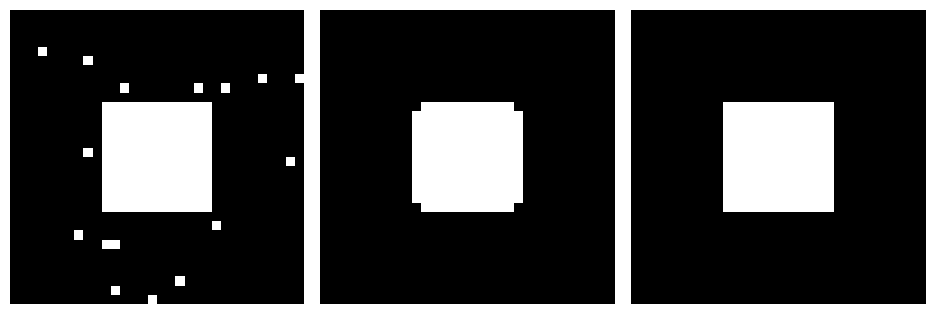

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(9.5, 3))
for i, img_arr in enumerate([square, open_square, reconstruction]):
    axes[i].imshow(img_arr, interpolation='nearest', cmap='gray')
    axes[i].axis("off")

plt.subplots_adjust(wspace=0, hspace=0.02, top=0.99, bottom=0.01, left=0.01, right=0.99)

#### **Closing**: dilation + erosion

Many other mathematical morphology operations: hit and miss transform, tophat,
etc.

## Feature extraction

### Edge detection

Synthetic data:

In [52]:
im = np.zeros((256, 256))
im[64:-64, 64:-64] = 1
im = sp.ndimage.rotate(im, 15, mode='constant')
im = sp.ndimage.gaussian_filter(im, 8)

Use a **gradient operator** (**Sobel**) to find high intensity variations:

In [53]:
# Filter x and y.
sx = sp.ndimage.sobel(im, axis=0, mode="constant")
sy = sp.ndimage.sobel(im, axis=1, mode="constant")
# Combine x and y.
sob = np.hypot(sx, sy)

In [54]:
# Make a noisy image.
# Set random seed.
rng = np.random.default_rng(27446968)

noisy_im = im + 0.07 * rng.random(im.shape)

# Filter x and y.
n_sx = sp.ndimage.sobel(noisy_im, axis=0, mode="constant")
n_sy = sp.ndimage.sobel(noisy_im, axis=1, mode="constant")
# Combine x and y.
noisy_sob = np.hypot(n_sx, n_sy)

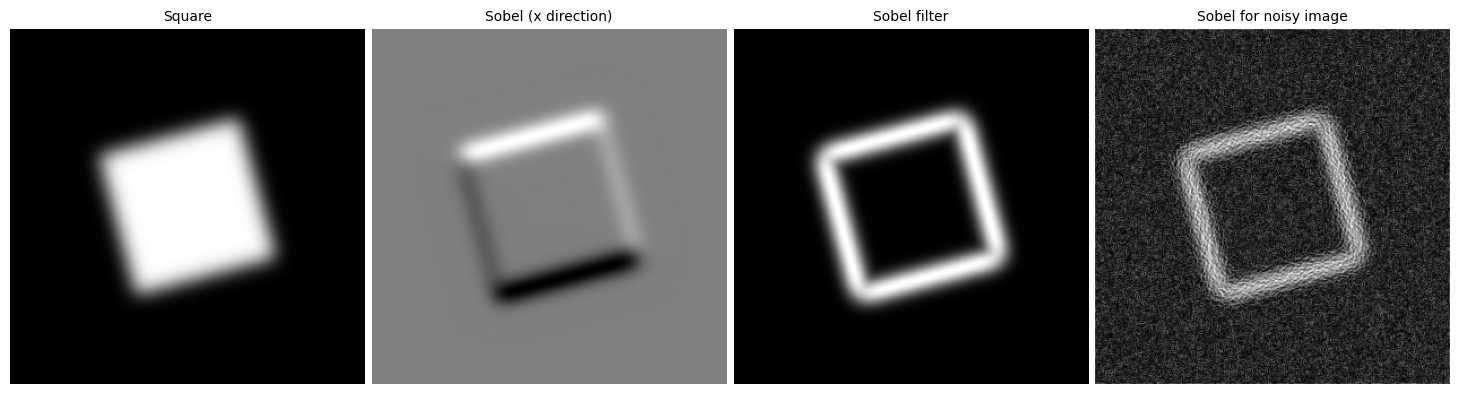

In [55]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
for i, (name, img_arr) in enumerate([
    ['Square', im],
    ['Sobel (x direction)', sx],
    ['Sobel filter', sob],
    ['Sobel for noisy image', noisy_sob]]):
    axes[i].imshow(img_arr, cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(name, fontsize=10)

plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=0.9);

### Segmentation

#### **Histogram-based** segmentation (no spatial information)

In [56]:
n = 10
l = 256
im = np.zeros((l, l))
rng = np.random.default_rng(27446968)
points = l*rng.random((2, n**2))
im[(points[0]).astype(int), (points[1]).astype(int)] = 1
im = sp.ndimage.gaussian_filter(im, sigma=l/(4.*n))

In [57]:
mask = (im > im.mean()).astype(float)
mask += 0.1 * im
img = mask + 0.2*rng.standard_normal(mask.shape)

In [58]:
hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
binary_img = img > 0.5

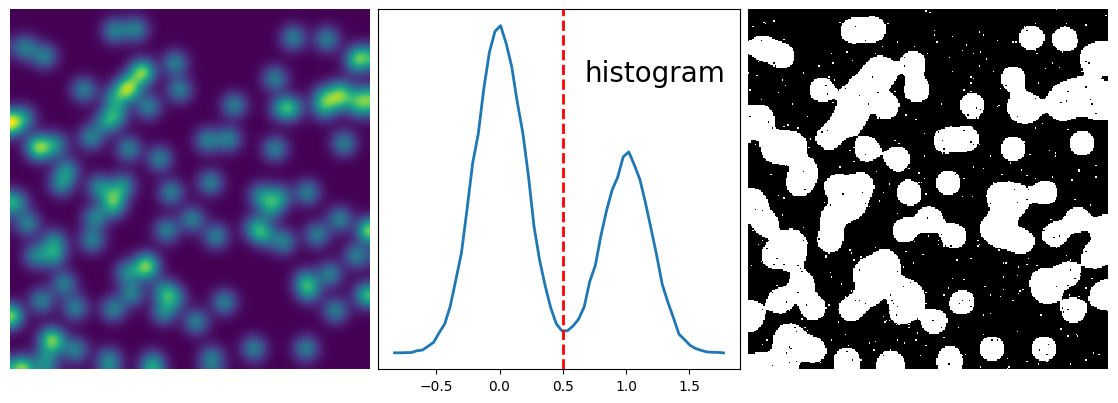

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(11, 4))
axes[0].imshow(im)
axes[0].axis("off")
axes[1].plot(bin_centers, hist, lw=2)
axes[1].axvline(0.5, color="r", ls="--", lw=2)
axes[1].text(0.57, 0.8, "histogram", fontsize=20, transform=axes[1].transAxes)
axes[1].set_yticks([])
axes[2].imshow(binary_img, cmap="gray", interpolation="nearest")
axes[2].axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)

Use mathematical morphology to clean up the result:

In [60]:
# Remove small white regions
open_img = sp.ndimage.binary_opening(binary_img)
# Remove small black hole
close_img = sp.ndimage.binary_closing(open_img)

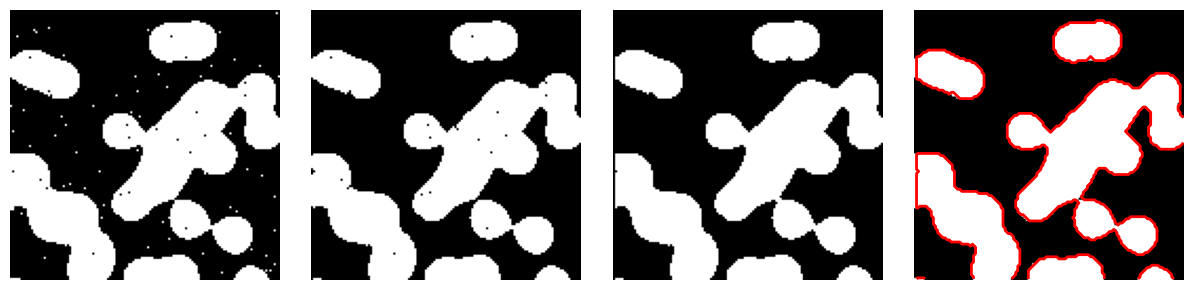

In [61]:
L = 128

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, img_arr in enumerate([binary_img, open_img, close_img, mask]):
    axes[i].imshow(img_arr[:L, :L], cmap='gray')
    axes[i].axis("off")

axes[-1].contour(close_img[:L, :L], [0.5], linewidths=2, colors="r")

plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)

::: {exercise-start}
:label: img-proc-erode-ex
:class: dropdown
:::

Check that reconstruction operations (erosion + propagation) produce a
better result than opening/closing. Start with:

In [62]:
eroded_img = sp.ndimage.binary_erosion(binary_img)
reconstruct_img = sp.ndimage.binary_propagation(eroded_img, mask=binary_img)

::: {exercise-end}
:::

::: {solution-start} img-proc-erode-ex
:class: dropdown
:::

In [63]:
eroded_img = sp.ndimage.binary_erosion(binary_img)
reconstruct_img = sp.ndimage.binary_propagation(eroded_img, mask=binary_img)
tmp = np.logical_not(reconstruct_img)
eroded_tmp = sp.ndimage.binary_erosion(tmp)
reconstruct_final = np.logical_not(sp.ndimage.binary_propagation(eroded_tmp, mask=tmp))
np.abs(mask - close_img).mean()

np.float64(0.006406997327240807)

In [64]:
np.abs(mask - reconstruct_final).mean()

np.float64(0.0008223210826911714)

::: {solution-end}
:::

::: {exercise-start}
:label: img-proc-denoise-hist-ex
:class: dropdown
:::

Check how a first denoising step (e.g. with a median filter) modifies the
histogram, and check that the resulting histogram-based segmentation is more
accurate.

::: {exercise-end}
:::

:::{admonition} See also

More advanced segmentation algorithms are found in the
`scikit-image`: see {ref}`scikit-image`.
:::

### Useful algorithms from other packages

Other Scientific Packages provide algorithms that can be useful for
image processing. In this example, we use the spectral clustering
function of the `scikit-learn` in order to segment glued objects.

<!-- #endregion -->

In [65]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

In [66]:
l = 100
x, y = np.indices((l, l))

In [67]:
center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)
radius1, radius2, radius3, radius4 = 16, 14, 15, 14

In [68]:
circle1 = (x - center1[0])**2 + (y - center1[1])**2 < radius1**2
circle2 = (x - center2[0])**2 + (y - center2[1])**2 < radius2**2
circle3 = (x - center3[0])**2 + (y - center3[1])**2 < radius3**2
circle4 = (x - center4[0])**2 + (y - center4[1])**2 < radius4**2

In [69]:
# 4 circles
img = circle1 + circle2 + circle3 + circle4
mask = img.astype(bool)
img = img.astype(float)

In [70]:
rng = np.random.default_rng()
img += 1 + 0.2*rng.standard_normal(img.shape)
# Convert the image into a graph with the value of the gradient on
# the edges.
graph = image.img_to_graph(img, mask=mask)

In [71]:
# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data/graph.data.std())

In [72]:
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

![](image_spectral_clustering.png)

## Measuring object properties: `scipy.ndimage.measurements`

Synthetic data:

In [73]:
n = 10
l = 256
im = np.zeros((l, l))
rng = np.random.default_rng(27446968)
points = l * rng.random((2, n**2))
im[(points[0]).astype(int), (points[1]).astype(int)] = 1
im = sp.ndimage.gaussian_filter(im, sigma=l/(4.*n))
mask = im > im.mean()

### Analysis of connected components

Label connected components: `scipy.dimage.label`:

In [74]:
label_im, nb_labels = sp.ndimage.label(mask)
nb_labels # how many regions?

28

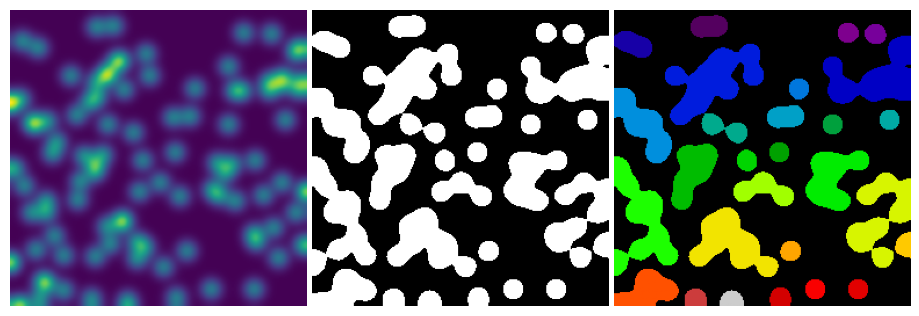

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, (img_arr, cmap) in enumerate([
    [im, 'viridis'],
    [mask, 'gray'],
    [label_im, 'nipy_spectral']]):
    axes[i].imshow(img_arr, cmap=cmap)
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=1);

Compute size, mean_value, etc. of each region:

In [76]:
sizes = sp.ndimage.sum(mask, label_im, range(nb_labels + 1))
mean_vals = sp.ndimage.sum(im, label_im, range(1, nb_labels + 1))

Clean up small connect components:

In [77]:
mask_size = sizes < 1000
remove_pixel = mask_size[label_im]
remove_pixel.shape

(256, 256)

In [78]:
label_im[remove_pixel] = 0

Now reassign labels with `np.searchsorted`:

In [79]:
labels = np.unique(label_im)
label_im = np.searchsorted(labels, label_im)

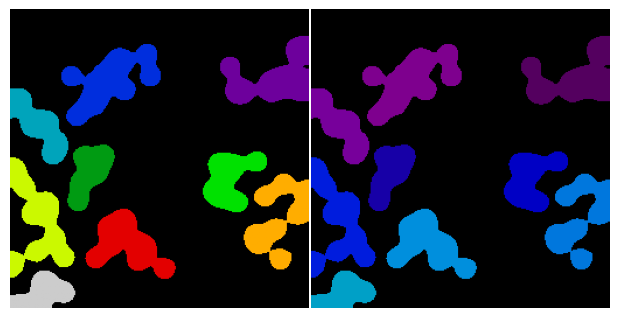

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(label_im, cmap="nipy_spectral")
axes[0].axis("off")
axes[1].imshow(label_im, vmax=nb_labels, cmap="nipy_spectral")
axes[1].axis("off")

plt.subplots_adjust(wspace=0.01, hspace=0.01, top=1, bottom=0, left=0, right=1)

Find region of interest enclosing object:

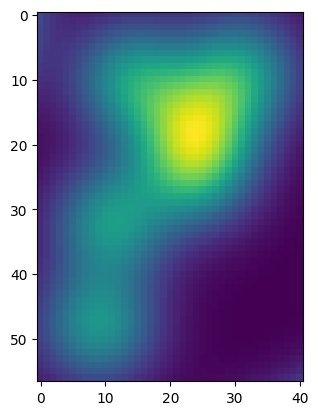

In [81]:
slice_x, slice_y = sp.ndimage.find_objects(label_im)[3]
roi = im[slice_x, slice_y]
plt.imshow(roi);

Other spatial measures: `scipy.ndimage.center_of_mass`,
`scipy.ndimage.maximum_position`, etc.

Can be used outside the limited scope of segmentation applications.

Example: block mean:

In [82]:
f = sp.datasets.face(gray=True)
sx, sy = f.shape
X, Y = np.ogrid[0:sx, 0:sy]
regions = (sy//6) * (X//4) + (Y//6)  # note that we use broadcasting
block_mean = sp.ndimage.mean(f, labels=regions, index=np.arange(1,
    regions.max() +1))
block_mean.shape = (sx // 4, sy // 6)

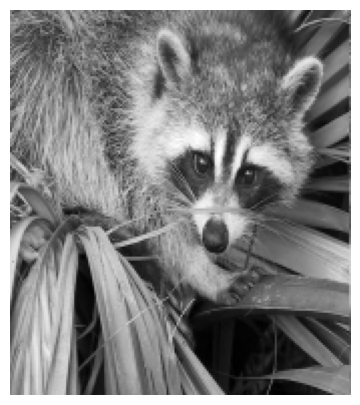

In [83]:
plt.figure(figsize=(5, 5))
plt.imshow(block_mean, cmap="gray")
plt.axis("off");

When regions are regular blocks, it is more efficient to use stride
tricks ({ref}`stride-manipulation-label`).

Non-regularly-spaced blocks: radial mean:

In [84]:
sx, sy = f.shape
X, Y = np.ogrid[0:sx, 0:sy]
r = np.hypot(X - sx/2, Y - sy/2)
rbin = (20* r/r.max()).astype(int)
radial_mean = sp.ndimage.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))

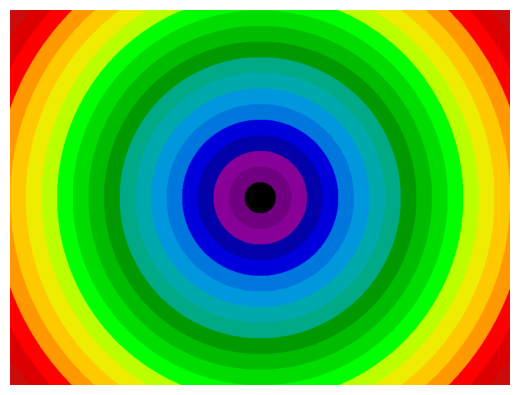

In [85]:
plt.figure(figsize=(5, 5))
plt.axes((0, 0, 1, 1))
plt.imshow(rbin, cmap="nipy_spectral")
plt.axis("off");

### Other measures

Correlation function, Fourier/wavelet spectrum, etc.

One example with mathematical morphology: [granulometry](https://en.wikipedia.org/wiki/Granulometry_%28morphology%29)

In [86]:
def disk_structure(n):
    struct = np.zeros((2 * n + 1, 2 * n + 1))
    x, y = np.indices((2 * n + 1, 2 * n + 1))
    mask = (x - n)**2 + (y - n)**2 <= n**2
    struct[mask] = 1
    return struct.astype(bool)

In [87]:
def granulometry(data, sizes=None):
    s = max(data.shape)
    if sizes is None:
        sizes = range(1, s/2, 2)
    granulo = [sp.ndimage.binary_opening(data, \
        structure=disk_structure(n)).sum() for n in sizes]
    return granulo

In [88]:
rng = np.random.default_rng(27446968)
n = 10
l = 256
im = np.zeros((l, l))
points = l*rng.random((2, n**2))
im[(points[0]).astype(int), (points[1]).astype(int)] = 1
im = sp.ndimage.gaussian_filter(im, sigma=l/(4.*n))

In [89]:
mask = im > im.mean()
granulo = granulometry(mask, sizes=np.arange(2, 19, 4))

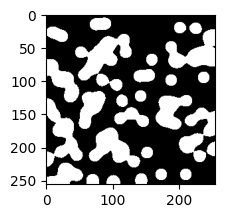

In [90]:
# Do the plot.
plt.figure(figsize=(6, 2.2))
plt.subplot(121)
plt.imshow(mask, cmap="gray")

In [91]:
opened = sp.ndimage.binary_opening(mask, structure=disk_structure(10))
opened_more = sp.ndimage.binary_opening(mask, structure=disk_structure(14))

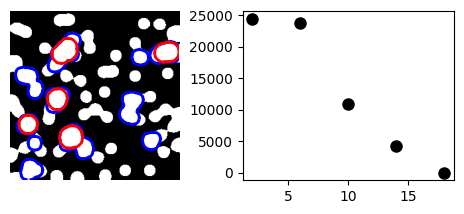

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.2))
axes[0].imshow(mask, cmap="gray")
axes[0].contour(opened, [0.5], colors="b", linewidths=2)
axes[0].contour(opened_more, [0.5], colors="r", linewidths=2)
axes[0].axis("off")
axes[1].plot(np.arange(2, 19, 4), granulo, "ok", ms=8)

:::{admonition} See also

More on image-processing:

- The chapter on {ref}`Scikit-image <scikit-image>`
- Other, more powerful and complete modules:
  [OpenCV](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html) (Python
  bindings), [CellProfiler](https://www.cellprofiler.org),
  [ITK](https://itk.org/) with Python bindings
  :::